In [1]:
import os
import sys
import numpy as np
import librosa
from math import ceil
import torch
from torch import nn, optim
import torch.nn.functional as F
from tqdm.notebook import tqdm
from fractions import Fraction
from torch.utils.data import DataLoader, TensorDataset
import pickle
from time import time
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import random
from math import ceil

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MEL_DIM=80
HIDDEN_DIM=64
DIC={
    0:[0, 0, 0, 0], 1:[0, 0, 0, 1], 2:[0, 0, 1, 0], 3:[0, 0, 1, 1],
    4:[0, 1, 0, 0], 5:[0, 1, 0, 1], 6:[0, 1, 1, 0], 7:[0, 1, 1, 1],
    8:[1, 0, 0, 0], 9:[1, 0, 0, 1], 10:[1, 0, 1, 0], 11:[1, 0, 1, 1],
    12:[1, 1, 0, 0], 13:[1, 1, 0, 1], 14:[1, 1, 1, 0], 15:[1, 1, 1, 1]
}
OUT_DIM=len(DIC)

In [2]:
def music_mel(y,sr,step=10,mel_dim=128):#默认step是10毫秒
    hop_length = int(np.floor(sr / (1000/step)))  # 计算hop_length
    # 提取音频特征
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr,n_mels=mel_dim,hop_length=hop_length)
    log_spectrogram = Normalization(librosa.power_to_db(spectrogram))
    return np.transpose(log_spectrogram)

def label2note(data):#将数组的标签索引转化为note排列
    '''data是一个形状为(labels,)的一维数组'''
    global DIC
    res=np.zeros((data.shape[0],4))
    for i in DIC.keys():
        res[data == i] = np.array(DIC[i])
    return res
    
def Normalization(datas):
    Min = np.min(datas)
    Max = np.max(datas)
    return (datas-Min)/(Max-Min)

def label2FullNote(data):#返回一个音符生成位置全填充为1的的数组
    '''data是一个形状为(labels,)的一维数组'''
    res=np.zeros((data.shape[0],3))
    res[data != 0] = 1
    return res.transpose()



In [40]:
class N(nn.Module):
    def __init__(self):
        global DIC,MEL_DIM,HIDDEN_DIM
        super(N, self).__init__()
        self.relu=nn.ReLU()        
        self.lstm=nn.LSTM(24,128, num_layers=2,dropout=0,bidirectional=False,batch_first=True)#不能使用双向
        self.fc0=nn.Linear(128,16)
        
    def forward(self,ln,d1,d2):
        Input=torch.cat((ln,d1,d2),dim=-1)
        lstm_out,_=self.lstm(Input)
        out=self.fc0(lstm_out)
        return out
    
    

In [4]:
with open(f'train data/music_data1.pkl', 'rb') as file:
    music_data = pickle.load(file)
with open(f'train data/labels_data1.pkl', 'rb') as file:
    labels_data = pickle.load(file)

with open(f'train data/valid_music_data.pkl', 'rb') as file:
    valid_music = pickle.load(file)
with open(f'train data/valid_labels_data.pkl', 'rb') as file:
    valid_label = pickle.load(file)
    
with open(f'train data/test_music_data.pkl', 'rb') as file:
    test_music = pickle.load(file)
with open(f'train data/test_labels_data.pkl', 'rb') as file:
    test_label = pickle.load(file) 

In [47]:
def get_frame_labels(labels):#labels : 1D array
    #返回当前note的前1个note键型，这通常代表了一个节拍
    #返回当前note与前后note的距离,分为8个类别
    global DIC
    res_l=[]
    distincts=[]
    di=0
    #labels=np.pad(labels,(seq_len,seq_len+1))
    for i in range(labels.shape[0]):
        if labels[i]>=1:
            if i-di<=5:#约50毫秒以内，通常是32分音符
                di_type=[1,0,0,0,0,0,0,0]
            elif i-di<=10:
                di_type=[0,1,0,0,0,0,0,0]
            elif i-di<=20:
                di_type=[0,0,1,0,0,0,0,0]
            elif i-di<=40:
                di_type=[0,0,0,1,0,0,0,0]
            elif i-di<=80:
                di_type=[0,0,0,0,1,0,0,0]
            elif i-di<=160:
                di_type=[0,0,0,0,0,1,0,0]
            elif i-di<=320:
                di_type=[0,0,0,0,0,0,1,0]
            else:
                di_type=[0,0,0,0,0,0,0,1]
            distincts.append(di_type)
            di=i
            res_l.append(labels[i])
    last_note=[0]+res_l[:-1]
    for i in range(len(last_note)):#将前一位的note转化为独热码
        note=DIC[last_note[i]]
        note_one_hots=[]
        for j in note:
            if j==0:
                one_hot=[1,0]
            else:
                one_hot=[0,1]
            note_one_hots+=one_hot
        last_note[i]=note_one_hots
    res_l=np.array(res_l)
    last_note=np.array(last_note)
    distincts1=np.array(distincts)
    distincts.append([0,0,0,0,0,0,0,1])
    distincts=distincts[1:]
    distincts2=np.array(distincts)
    
    '''
        res_l：返回的label，用于计算loss
        last_note:上一个音符的排列，以独热码表示
        distincts1,distincts2:前一个音符的距离和下一个音符的距离
    '''
    return res_l,last_note,distincts1,distincts2

def tensor_norm(tensor):
    max_=tensor.max()
    min_=tensor.min()
    return (tensor-min_)/(max_-min_)

def get_acc(pred,label):
    corr=0
    pred=torch.argmax(pred,dim=1).cpu()
    label=label.cpu()
    for i in range(len(label)):
        if pred[i].item()==label[i].item():
            corr+=1
    return corr/len(label)
    

In [51]:
model=N().to(device)
optimizer = optim.SGD(model.parameters(),lr=0.1)
criterion = nn.CrossEntropyLoss()

In [54]:
# '''加载模型继续训练'''
# checkpoint = torch.load('model/N/best model.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [52]:
losses=[]
acc=[]
losses_t=[]
acc_t=[]

In [53]:
for epoch in tqdm(range(100)):
#     if epoch+1%10==0 :
#         for param_group in optimizer.param_groups:
#             param_group['lr'] *= 0.9  # 手动设置新的学习率
    loss_temp=[]
    acc_temp=[]
    if (epoch+1)%10==0:
        torch.save({'model_state_dict': model.state_dict(),
                     'optimizer_state_dict': optimizer.state_dict(),
                    }, f'model/CBiLSTM/N/{epoch}.pth')
    if epoch>2:
        if acc_t[-1]>=max(acc_t):
            torch.save({'model_state_dict': model.state_dict(),
                         'optimizer_state_dict': optimizer.state_dict(),
                        }, f'model/CBiLSTM/N/best model.pth')
    for i in tqdm(range(len(music_data))):
        #获取有音符时间步的音符排列，上一个时间步音符的排列，音符与上一个音符的距离，音符与下一个音符的距离
        labels_,last_note,distinct1,distinct2=get_frame_labels(labels_data[i])
        labels_=torch.tensor(labels_,dtype=torch.long).to(device)
        distinct1=torch.tensor(distinct1,dtype=torch.float).to(device)
        distinct2=torch.tensor(distinct2,dtype=torch.float).to(device)
        last_note=torch.tensor(last_note,dtype=torch.float).to(device)
        out=model(last_note,distinct1,distinct2)
        loss=criterion(out.squeeze(),labels_)
        loss_temp.append(loss.item())
        acc_temp.append(get_acc(out,labels_))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    losses.append(sum(loss_temp)/len(loss_temp))
    acc.append(sum(acc_temp)/len(acc_temp))
    loss_temp=[]
    acc_temp=[]
    with torch.no_grad():
        for i in tqdm(range(len(test_music))):
            labels_t,last_note_t,distinct_t1,distinct_t2=get_frame_labels(test_label[i])
            labels_t=torch.tensor(labels_t,dtype=torch.long).to(device)
            distinct_t1=torch.tensor(distinct_t1,dtype=torch.float).to(device)
            distinct_t2=torch.tensor(distinct_t2,dtype=torch.float).to(device)
            last_note_t=torch.tensor(last_note_t,dtype=torch.float).to(device)
            out_t=model(last_note_t,distinct_t1,distinct_t2)
            loss=criterion(out_t.squeeze(),labels_t)
            loss_temp.append(loss.item())
            acc_temp.append(get_acc(out_t,labels_t))
        losses_t.append(sum(loss_temp)/len(loss_temp))
        acc_t.append(sum(acc_temp)/len(acc_temp))
        loss_temp=[]
        acc_temp=[]
    print(epoch,losses[-1],acc[-1],losses_t[-1],acc_t[-1])

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0 2.619251179695129 0.1601596673234488 2.5078439235687258 0.1630002376643876


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

1 2.4683679014444353 0.17406435465847056 2.453971004486084 0.254849861559435


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

2 2.443069177865982 0.18327884420477816 2.4438151121139526 0.17403203360021027


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

3 2.4363095432519914 0.18592632792937622 2.439617085456848 0.1742335724942346


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

4 2.433025839924812 0.19081179355065653 2.4373820781707765 0.17538057652102526


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

5 2.430951663851738 0.19564825821260787 2.4359212160110473 0.17770138372867159


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

6 2.42938871383667 0.20089745827723338 2.434754490852356 0.18306933458763325


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

7 2.4280470639467238 0.20620975543172052 2.433656120300293 0.1938879332152522


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

8 2.426776322722435 0.21174579975340987 2.4325088977813722 0.2081757929578345


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

9 2.4254832744598387 0.2191937212467529 2.4312429428100586 0.22824694906362927


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

10 2.4241003066301348 0.2264749203397344 2.4298083543777467 0.24534390316669596


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

11 2.4225722342729568 0.23404177763769102 2.4281636238098145 0.25785274391866564


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

12 2.4208485186100006 0.2423359393912053 2.4262720346450806 0.2691998653062087


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

13 2.4188817113637926 0.25018046168577224 2.424100160598755 0.2741262922644144


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

14 2.4166268736124037 0.2575493251229838 2.421617531776428 0.2791265742390413


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

15 2.4140366941690443 0.2650968370582099 2.4187854051589968 0.2839147450811081


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

16 2.411048576235771 0.2712923415445769 2.415532112121582 0.2871403195993031


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

17 2.4075516551733016 0.2769034092810186 2.4117066144943236 0.29170464033473686


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

18 2.4033353984355927 0.2818267722160106 2.40701220035553 0.29468060425370124


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

19 2.3980180591344835 0.2850596664855243 2.400926876068115 0.2958198202054675


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

20 2.390934079885483 0.2867977467137403 2.3925570487976073 0.2959043833035031


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

21 2.3809170722961426 0.2881186029889239 2.380328321456909 0.2967629099919309


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

22 2.365826463699341 0.2891658532574539 2.361299991607666 0.29797402110050625


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

23 2.341551959514618 0.2905810104368275 2.329855537414551 0.29797731357954255


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

24 2.300561311841011 0.29196844232266733 2.2771302700042724 0.3002031159930154


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

25 2.2358978539705276 0.29327440535290356 2.2050264358520506 0.3014639249522998


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

26 2.1667545214295387 0.29311906259824516 2.147788202762604 0.3016804698984877


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

27 2.1231064766645433 0.29624525634837146 2.1133941531181337 0.3026882876302618


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

28 2.0967947036027907 0.30143272302714785 2.0899329662322996 0.30602454727039274


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

29 2.075637874007225 0.30891140403207523 2.069330859184265 0.31676183660625495


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

30 2.0541780635714533 0.31870712207313207 2.047189736366272 0.3282293782338278


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

31 2.0280447989702224 0.3321352660994479 2.0192427396774293 0.3366381911173798


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

32 1.9918587177991867 0.34391067036906897 1.9806185841560364 0.34138097948362944


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

33 1.941414576768875 0.3529003951809583 1.931254255771637 0.3464020713754887


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

34 1.8817998617887497 0.36248301145310546 1.8797393918037415 0.3522282663828091


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

35 1.8190236642956734 0.3731349808666299 1.8266301512718202 0.35871369789906454


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

36 1.756822581589222 0.38265324578869675 1.7796879172325135 0.3633542110403072


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

37 1.7079433485865594 0.38781191721677916 1.745126473903656 0.36513849142209714


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

38 1.6728111669421195 0.3924853161176033 1.7189311265945435 0.3693655630128053


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

39 1.6462083116173745 0.39764064716202185 1.6978297710418702 0.37273117070547906


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

40 1.6246763855218886 0.4035299381002805 1.6798174858093262 0.37544180890243267


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

41 1.6061709225177765 0.4099636259680989 1.6634978532791138 0.38034213616844975


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

42 1.5896467179059983 0.4168666443020639 1.6481821656227111 0.38867906014829756


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

43 1.574693475663662 0.42329274352668433 1.6338700771331787 0.3955526081415756


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

44 1.561092060804367 0.429697363441709 1.620475161075592 0.40078512432520697


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

45 1.54860922396183 0.4358099710136976 1.6078434705734252 0.4051344828259233


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

46 1.5370835810899734 0.44044168477809553 1.5959131002426148 0.40944990850522467


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

47 1.5263608291745185 0.4444516773681224 1.584698748588562 0.41459601624534353


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

48 1.5163197994232178 0.4481852625014362 1.5740752816200256 0.42092407432398893


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

49 1.5068009734153747 0.452004722018457 1.5639326333999635 0.42462228588522233


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

50 1.4976961761713028 0.4555483808013016 1.5541347980499267 0.4289240760341205


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

51 1.4889002442359924 0.45878716443620926 1.5446209073066712 0.4318116719593765


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

52 1.480329030752182 0.46170323864899154 1.5353346109390258 0.4343772728074443


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

53 1.4718622416257858 0.464419297354016 1.526187813282013 0.43815496418303806


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

54 1.4634129226207733 0.46712949020867206 1.5170817732810975 0.4420487672828889


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

55 1.4548337951302528 0.4702868789010483 1.507856273651123 0.4475236154023638


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

56 1.445895479619503 0.473564588263155 1.4982042908668518 0.45151680806784694


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

57 1.4361497685313225 0.47701117652731045 1.4875501275062561 0.4574071263822372


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

58 1.424579843878746 0.4813646630365372 1.4745458483695983 0.46329851843778797


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

59 1.408957366645336 0.48702450500316746 1.4571046471595763 0.47170783376314274


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

60 1.387096218764782 0.4938696402370148 1.43730788230896 0.47944084658872865


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

61 1.3689546585083008 0.49923380990452604 1.4287291407585143 0.48150767759488533


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

62 1.3586227312684058 0.5018826628813684 1.4227848410606385 0.48320776726901754


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

63 1.3513308972120286 0.5034594851683427 1.417605447769165 0.4856620104369158


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

64 1.345305086672306 0.5045557092816914 1.4126405715942383 0.4882158594343541


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

65 1.339905282855034 0.5063415883566164 1.4079492926597594 0.49039798463094436


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

66 1.3348955154418944 0.5083623144973625 1.4034948825836182 0.4922268353898849


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

67 1.3302253648638724 0.5097252414419294 1.3991480588912963 0.49391140572315245


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

68 1.3256635621190072 0.5110362835867297 1.3947052478790283 0.495812724086348


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

69 1.3213758990168571 0.5122544680660429 1.3903641104698181 0.4965590251154377


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

70 1.3171565309166908 0.5137804068372651 1.3858702421188354 0.4974937550793486


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

71 1.3133071884512901 0.5151449025317724 1.381776475906372 0.4991438269426566


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

72 1.3088077753782272 0.5165498914140356 1.3770726799964905 0.5012390745559759


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

73 1.3045826211571694 0.5182368201034862 1.3725680232048034 0.5035899960044283


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

74 1.3004065617918967 0.5197779077772356 1.3681203365325927 0.5050629157643554


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

75 1.2962821215391158 0.5209205379114707 1.3637855052947998 0.5064903717665039


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

76 1.2921795144677162 0.5224934694417855 1.3595374822616577 0.5088907862901133


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

77 1.2880437582731248 0.5239031435844601 1.3555101990699767 0.5103558969414062


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

78 1.2839398875832557 0.5250008700608021 1.3516302824020385 0.5111372351575885


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

79 1.279923053085804 0.526023311058914 1.3479514241218566 0.5116879627091532


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

80 1.2760330215096474 0.5273003080331657 1.3442443251609801 0.5121946652293828


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

81 1.2721372574567795 0.5284052265681903 1.3407880425453187 0.5120076141866611


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

82 1.2682141549885273 0.5305946178369262 1.3373140335083007 0.5128591114453959


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

83 1.2643856942653655 0.5321730029859029 1.3344090223312377 0.5131151947370358


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

84 1.2606284327805042 0.5341819152238385 1.3311932921409606 0.5153299738067816


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

85 1.2569085583090782 0.5360901281348235 1.32871972322464 0.5171504620464068


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

86 1.2531807981431484 0.5379091557564561 1.3256261706352235 0.5185568921685964


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

87 1.249514600634575 0.5393234083506919 1.3229304909706117 0.518241463145105


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

88 1.245883622020483 0.540757347603438 1.3201859831809997 0.5192209001608064


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

89 1.2422709956765174 0.5424602676057741 1.3175695300102235 0.5210461064679652


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

90 1.2386467598378659 0.5439473579935653 1.3151209115982057 0.5217594757663664


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

91 1.2350621156394481 0.5454525961082932 1.312542724609375 0.5222417398650219


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

92 1.2315617598593236 0.5472814782278766 1.3100292801856994 0.5232342835074937


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

93 1.2281517066061496 0.5492762197055487 1.3077126145362854 0.5242589164799525


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

94 1.2248433493077755 0.5504410538801846 1.3055070638656616 0.5243319435415128


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

95 1.2216663666069507 0.5516516483506797 1.3034974575042724 0.5250767078565104


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

96 1.2186173483729363 0.5526288522872943 1.3018069386482238 0.5255179682294697


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

97 1.2156784042716027 0.553841538411399 1.300451123714447 0.526149952340539


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

98 1.2128510765731335 0.5549485942295934 1.2990680098533631 0.5266904022292859


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

99 1.2101310253143311 0.5563170319750734 1.2976515293121338 0.5267684587946693


In [54]:
#验证

# model=N().to(device)
# checkpoint = torch.load('model/CBiLSTM/N/best model.pth')
# model.load_state_dict(checkpoint['model_state_dict'])

loss_v=[]
acc_v=[]
loss_temp=[]
acc_temp=[]

with torch.no_grad():
    for i in tqdm(range(len(valid_music))):
        labels_t,last_note_t,distinct_t1,distinct_t2=get_frame_labels(valid_label[i])
        labels_t=torch.tensor(labels_t,dtype=torch.long).to(device)
        distinct_t1=torch.tensor(distinct_t1,dtype=torch.float).to(device)
        distinct_t2=torch.tensor(distinct_t2,dtype=torch.float).to(device)
        last_note_t=torch.tensor(last_note_t,dtype=torch.float).to(device)
        out_t=model(last_note_t,distinct_t1,distinct_t2)
        loss=criterion(out_t.squeeze(),labels_t)
        loss_temp.append(loss.item())
        acc_temp.append(get_acc(out_t,labels_t))
    loss_v.append(sum(loss_temp)/len(loss_temp))
    acc_v.append(sum(acc_temp)/len(acc_temp))
    loss_temp=[]
    acc_temp=[]
print(sum(loss_v)/len(loss_v),sum(acc_v)/len(acc_v))

  0%|          | 0/10 [00:00<?, ?it/s]

1.1449766278266906 0.575615863109183


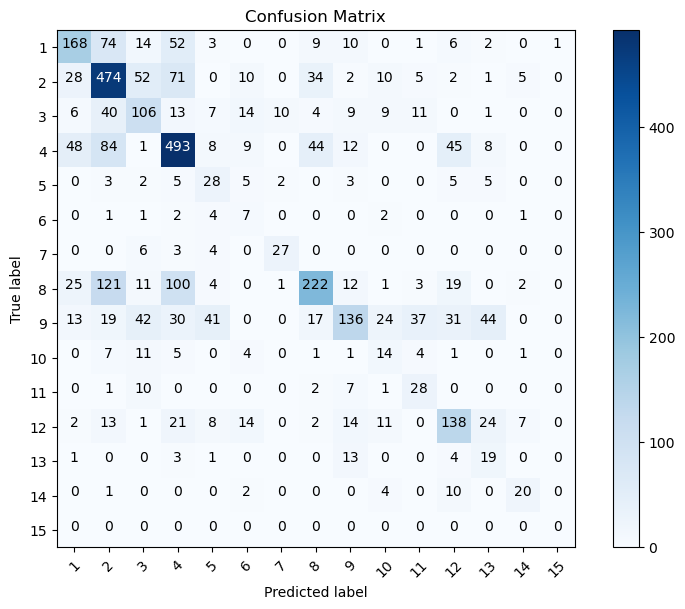

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
import itertools

cm = confusion_matrix(torch.argmax(out_t,dim=1).cpu().numpy(), labels_t.cpu().numpy())

# 使用 Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(15)  # 有15个类别
plt.xticks(tick_marks, [i for i in range(1,16)], rotation=45)
plt.yticks(tick_marks, [i for i in range(1,16)])

# 标注数值
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

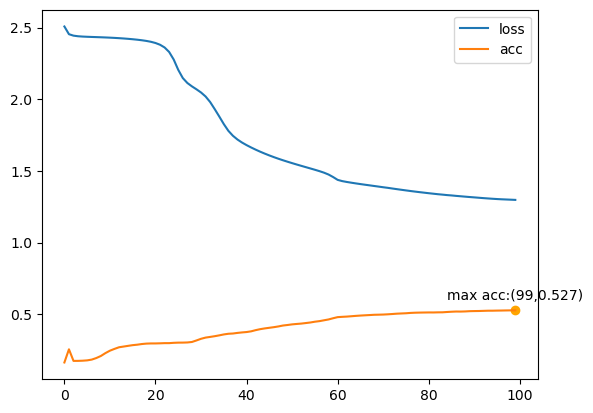

In [56]:
plt.plot(losses_t,label='loss')
plt.plot(acc_t,label='acc')
plt.scatter(x=acc_t.index(max(acc_t)),y=max(acc_t),color='orange')
plt.text(x=acc_t.index(max(acc_t)),y=max(acc_t)+0.1,s=f'max acc:({acc_t.index(max(acc_t))},{round(max(acc_t),3)})',ha='center',va='center')
plt.legend()
plt.show()

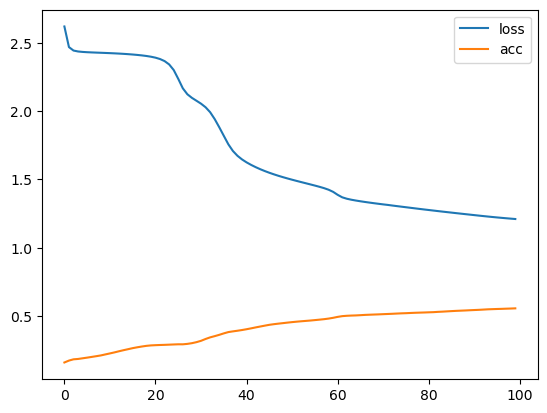

In [57]:
plt.plot(losses,label='loss')
plt.plot(acc,label='acc')
plt.legend()
plt.show()

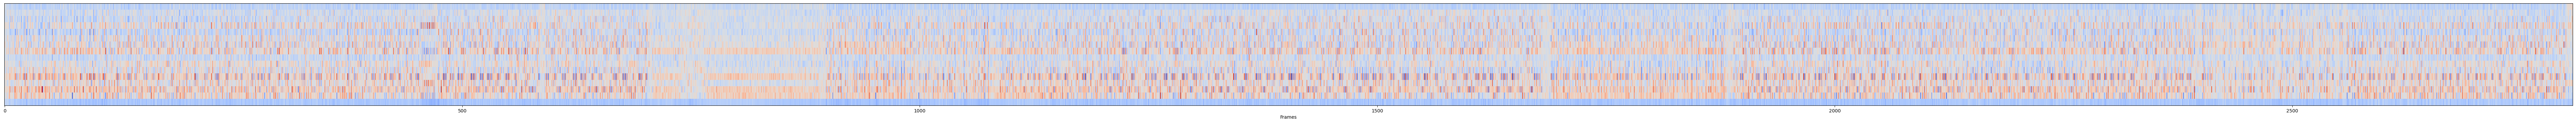

In [46]:
plt.figure(figsize=(100,4))
librosa.display.specshow((out_t).squeeze().cpu().detach().numpy().transpose(),x_axis='frames')

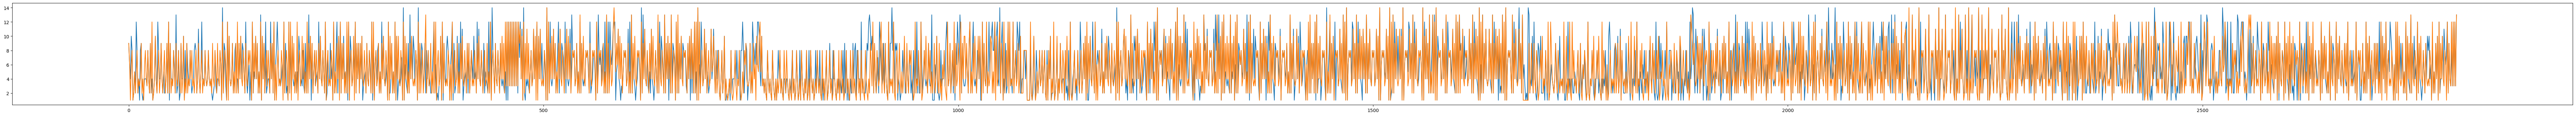

In [47]:
plt.figure(figsize=(100,4))
plt.plot(torch.argmax(out_t.reshape(-1,16),dim=1).cpu().detach().numpy())
plt.plot(test_label[i][test_label[i]>=1])

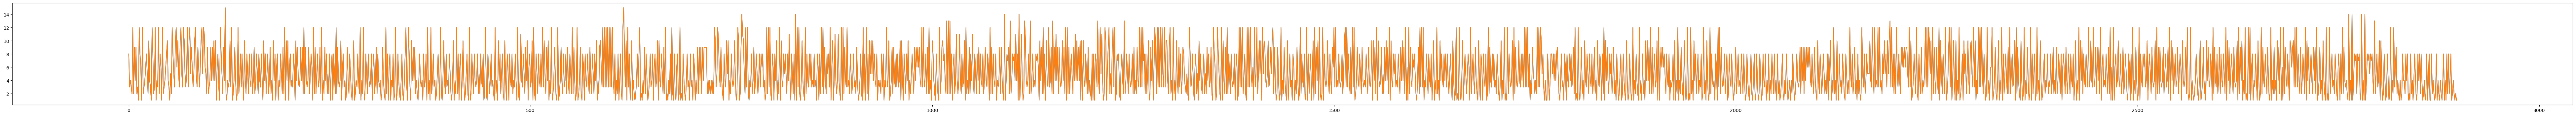

In [48]:
plt.figure(figsize=(100,4))
plt.plot(torch.argmax(out.reshape(-1,16),dim=1).cpu().detach().numpy())
plt.plot(labels_data[-1][labels_data[-1]>=1])